In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR,ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch import Tensor



import sklearn
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay,roc_curve


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm

### Dataset customisée par entraîner un modèle d'auto encodeur

In [67]:
class AE_Dataset(Dataset):

    """Cette classe à été créée afin de créer facilement un DataLoader de pytorch
    """
    def __init__(self, data):

        super(AE_Dataset,self).__init__()

        #La target d'un auto encoder est lui le donnée initial car n'oublions pas que l'objectif
        #de l'auto encodeur c'est de reconstituer la donnée initiale

        self.data = np.copy(data)
        self.targets = np.copy(data)


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return torch.tensor(self.data[index],dtype=torch.float32), torch.tensor(self.targets[index],dtype=torch.float32)


In [68]:
def confusin_matrix_display(ytest,ypred):
    metrics.ConfusionMatrixDisplay(confusion_matrix(ytest,ypred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

def precision_recall_display(ytest, ypred):
    precision, recall, _ = precision_recall_curve(ytest, ypred)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title("Precision_Recall_Curve")
    plt.show()

def roc_curve_disolay(ytest, ypred):
    fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    print(f"roc_auc {roc_auc}")
    display.plot()
    plt.title("ROC_Curve")
    plt.show()

def scores(ytest,ypred):
    df=pd.DataFrame({"f1_score" : [f1_score(ytest,ypred)],
                     "accuracy_score" : [accuracy_score(ytest,ypred)],
                     "precision_score" : [precision_score(ytest,ypred)],
                     "recall_score" : [recall_score(ytest,ypred)]
    })
    print(df)
    return df

def evaluation(ytrue,ypred):
    confusin_matrix_display(ytrue,ypred)
    precision_recall_display(ytrue, ypred)
    roc_curve_disolay(ytrue, ypred)
    scores(ytest,ypred)

def transform_target(target):
    """Args:
        target: np.ndarry or pd.DataFrame
    """
    n=target.shape[0]
    if isinstance(target,np.ndarray):
        target[target==1]=-1
        target[target==0]=1

    elif isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=-1
        target[target==0]=1
    return target


def inverse_transform_target(target):
    n=target.shape[0]
    if isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=0
        target[target==-1]=1

    elif isinstance(target,np.ndarray):
        target[target==1]=0
        target[target==-1]=1
    return target

In [76]:
class CustomDataset:

    def __init__(self, file_path, scaler,test_size=0.15, random_state=42):

        self.file_path = file_path
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = scaler

        self.data = None
        self.target = None

        # Chargement et prétraitement de la donnée
        self._load_data()
        self._preprocess_data()
        self._split_data()

        self.xtrain = self._xtrain # ce sont uniquement les données normales quui seront entraînées avec l'auto encoder
        self.ytrain = self.xtrain # La target d'un auto encoder est lui le donnée initial car n'oublions pas que l'objectif
                                # de l'auto encodeur c'est de reconstituer la donnée initiale

        # Par contre les données de test devront à la fois contenir les données normales et les données anormales
        #Ainsi les données de test seront la concatenation entre les données normales reservées pour le test et les données contenant que des 1

        # print(f"type(self.data.shape) {self.data.shape}")
        # print(f"type(self.self.shape) {self.target.shape}")
        # print(f"type(self.data[self.target==1]) {self.target==1}")
        # print(f"type(self.data[self.target==1]) {self.data[self.target==1]}")
        self.xtest = pd.concat([self._xtest, self.data[self.target==1]], axis=0)
        self.ytest = pd.concat([self._ytest, self.target[self.target==1]], axis=0)

        self.xtest.reset_index(drop=True, inplace=True)
        self.ytest.reset_index(drop=True, inplace=True)

        # Note : ytrain utilisé comme target lors de l'entraînement n'est le même format que ytest utilisé lors de la prédiction
        # ytrain =xtrain alors que ytest =target (labels)(0 pour donnée normale et 1 pour donnée anormale)


    def get_scaler(self):
        return self.scaler

    def _load_data(self):
        self.data = pd.read_csv(self.file_path)

        self.data.drop_duplicates(keep="last", inplace=True)
        self.target = self.data["Class"]
        self.data.drop(["Class", "Time"], axis=1,inplace=True)
        #self.target = self.data["class"]
        #self.data.drop(["class"], axis=1,inplace=True)

    def _preprocess_data(self):

        # Avec un modèle de réseaux de neurones profond, l'on n'est pas obligé de pré-traiter la donnée
        if self.scaler is not None:

            data_scaled_array = self.scaler.fit_transform(self.data)
            # self.data['Amount']=self.scaler.fit_transform(self.data['Amount'].values.reshape(self.data.shape[0],-1))

            #Il est impératif d'ajouter l'argument index lors de la créaction d'un dataframe à partir d'un numpy array
            # Dans notre cas, data_scaled_array est un tableau numpy. si l'argument "index" n'est pas ajouté alors l'index par défaut sera
            # RangeIndex. Le RangeIndex est incompatible avec la Index. Par exemple il sera impossible de concatener deux dataframes
            # Ou un dataframe et une serie dont l'un possède Index et l'autre RangeIndex
            self.data = pd.DataFrame(data_scaled_array, columns=self.data.columns,index=self.data.index)


    def _split_data(self):

        self._xtrain, self._xtest, self._ytrain, self._ytest = train_test_split(
            self.data, self.target, test_size=self.test_size, random_state=self.random_state, shuffle=True)

    def get_train_data(self):
        return self.xtrain, self.ytrain

    def get_test_data(self):
        return self.xtest, self.ytest

## Encoder Layer

In [70]:
class Encoder(nn.Module):

    def __init__(self,input_size: int, latent_size: int,dropout: float,device: str="cuda") -> None:

        super(Encoder,self).__init__()

        self.fc1=nn.Linear(in_features=input_size,out_features=25)
        self.relu1=nn.ReLU()
        self.dropout1=nn.Dropout(dropout)
        self.fc2=nn.Linear(in_features=25,out_features=20)
        self.relu2=nn.ReLU()
        self.fc3=nn.Linear(in_features=20,out_features=15)
        self.relu3=nn.ReLU()
        self.dropout2=nn.Dropout(dropout)
        self.fc4=nn.Linear(in_features=15,out_features=latent_size)

        self.device= torch.device("cuda") if device=="cuda" else torch.device("cpu")


    def forward(self,inputs: Tensor) -> Tensor:
        x=self.relu1(self.fc1(inputs))
        x=self.dropout1(x)
        x= self.relu2(self.fc2(x))
        x= self.relu3(self.fc3(x))
        x=self.dropout2(x)
        x=self=self.fc4(x)

        return x


## Decoder Layers

In [71]:
class Decoder(nn.Module):

    def __init__(self,latent_size: int, output_size: int,dropout: float,device: str="cuda") -> None:

        super(Decoder,self).__init__()

        self.fc1=nn.Linear(in_features=latent_size,out_features=15)
        self.relu1=nn.LeakyReLU(0.2)
        self.dropout1=nn.Dropout(dropout)
        self.fc2=nn.Linear(in_features=15,out_features=20)
        self.relu2=nn.LeakyReLU(0.2)
        self.fc3=nn.Linear(in_features=20,out_features=25)
        self.relu3=nn.LeakyReLU(0.2)
        self.dropout2=nn.Dropout(dropout)
        self.fc4=nn.Linear(in_features=25,out_features=output_size)

        self.device= torch.device("cuda") if device=="cuda" else torch.device("cpu")



    def forward(self,inputs: Tensor) -> Tensor:
        x=self.relu1(self.fc1(inputs))
        x=self.dropout1(x)
        x= self.relu2(self.fc2(x))
        x= self.relu3(self.fc3(x))
        x=self.dropout2(x)
        x=self=self.fc4(x)

        return x

## AutoEncoder

In [72]:
class AutoEncoder(nn.Module):

    def __init__(self,input_size: int,latent_size: int,output_size: int,contamination: float=0.5,dropout: float=0.1,device: str="cuda") -> None:

        super(AutoEncoder,self).__init__()

        self.encoder=Encoder(input_size=input_size, latent_size = latent_size,device="cuda",dropout=0.1)
        self.latent=None
        self.decoder=Decoder(latent_size =latent_size, output_size=output_size,device="cuda",dropout=0.1)
        self.offset=contamination

        self.device= torch.device("cuda") if device=="cuda" else torch.device("cpu")

        self.is_fitted=False

        self.train_curve=[]
        self.val_curve=[]



    def forward(self,inputs: Tensor) -> Tensor:
        x=self.encoder(inputs)
        self.latent=x
        x=self.decoder(x)

        return x


    def train_one_epoch(self,train_loader:DataLoader,optimizer,scheduler,loss_fn):

        """The function is use to train one epoch of the model
            Args:
                optimizer      : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                loss_function  : The loss function to use during the model training. CrossEntropyLoss and MSELoss are very often use for respectively
                                classification and regression problem
                train_loader   : A torch DataLoader which is use to iterate through the data during train step

            Return : The last loss value on the train_loader

        """
        running_loss = 0.0
        last_loss = 0.0

        self.loss_fn=loss_fn

        for batch_index, batch in enumerate(train_loader):

            optimizer.zero_grad() # Putting gradient to zero in order to accumulate upcoming gradient


            data,target=batch[0].to(self.device),batch[1].to(self.device)

            outputs=self.forward(data) # Making prediction

            loss=loss_fn(outputs.to(self.device),target) # Computing the loss
            loss.backward() # Computing the gradient

            running_loss+=loss.item() # Accumulation loss through one epoch

            optimizer.step() # Updating weights

            if batch_index%100==99:
                last_loss=running_loss/100 # Computing loss per batch
                # print("batch {} loss {}".format(batch_index+1,last_loss))
        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        print("SGD lr %.8f -> %.8f" % (before_lr, after_lr))
        return last_loss


    def validation_one_epoch(self,validation_loader,loss_fn):

        """The function is used to train one epoch of the model
            Args:
                optimizer       : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                loss_function   : The loss function to use during the model validation. Same as the training one
                val_loader      : A torch DataLoader which is use to iterate through the data during validation step

            Return : The last loss value on the val_loader

        """
        avg_vloss = 0.
        running_loss=0.
        with torch.no_grad() :
            for batch in validation_loader:

                data,target=batch[0].to(self.device),batch[1].to(self.device)
                outputs=self.forward(data) # Making prediction

                loss=loss_fn(outputs,target) # Computing the loss

                running_loss+=loss.item() # Accumulation loss through one epoch

        avg_vloss=running_loss/len(validation_loader)

        return avg_vloss




    def evaluation(self,y_test,predictions,metric="mse"):
        # Evaluate the model
        if metric=="mse" :print("Mean Squared Error (MSE):", mean_squared_error(y_test, predictions))
        elif metric =="mae" :print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, predictions))

    def predict(self, dataloader):
        assert self.is_fitted==True, "Le modèle n'est pas encore entraîné donc ne peut pas faire de prédiction"
        return self.decision_function(dataloader)


    def decision_function(self,dataloader: DataLoader):

        dataframe=self.compute_score_sample(dataloader)
        dataframe.loc[-dataframe["score_sample"] < (-dataframe["score_sample"]).quantile(self.offset), "label"] = -1

        return dataframe['label']

    def score_sample(self,dataloader: DataLoader,loss_fn=nn.MSELoss(reduction='none')):

        dataframe=self.compute_score_sample(self,dataloader)

        return dataframe["score_sample"]

    def compute_score_sample(self,dataloader: DataLoader,loss_fn=nn.MSELoss(reduction='none')):

        assert loss_fn.reduction=='none',"La fonction pour le calcul des erreurs de reconstitution ne possède pas les bonne argument"

        reconstition_errors=[]
        with torch.no_grad() :
            for batch in dataloader:

                data,target=batch[0].to(self.device),batch[1].to(self.device)
                outputs=self.forward(data) # Making prediction

                loss=loss_fn(outputs,target) # Computing the loss

                for item in loss:
                    reconstition_errors.append(torch.sum(item).item())


        dataframe=pd.DataFrame({
            "score_sample" : reconstition_errors,
            "label" :[1 for _ in range(len(reconstition_errors))]
        })

        return dataframe


    def fit(self,train_loader,validation_loader,optimizer,scheduler,loss_fn,epochs=100,device="cuda"):
        """The function is used to train the model through many epochs
            Args:
                optimizer             : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                train_loader          : A torch DataLoader which is use to iterate through the data during train step
                loss_function         : The loss function to use during the model validation. Same as the training one
                validataion_loader    : A torch DataLoader which is use to iterate through the data during validation step

            Return : No return

        """
        self.to(self.device)
        best_avg_vloss=1_000_000_000
        for epoch in range(epochs):
            # print("\n")
            print("EPOCHS : {}".format(epoch +1))
            self.train(True) # Activate training mode
            avg_loss=self.train_one_epoch(train_loader,optimizer,scheduler,loss_fn) # training the model on an epoch

            self.eval() # Setting the evaluation mode so that no gradient will be compute, that will save forward pass time
            avg_vloss=self.validation_one_epoch(validation_loader,loss_fn) # Evalution the model after one epoch
            print(f"Loss {avg_loss} vs Validation_loss  {avg_vloss}")
            self.train_curve.append(avg_loss)
            self.val_curve.append(avg_vloss)

            if avg_vloss < best_avg_vloss :
                best_avg_vloss=avg_vloss
                #model_path='/home/dah/timeSeries/time_series_forcasting/models/model_{}'.format(datetime.now().strftime('%Y%m%d_%H%'))
                #torch.save(self.cpu().state_dict(),model_path)
                self.to(self.device)
                self.to(self.device)
        self.is_fitted=True

        return {
            "train":self.train_curve,
            "val":self.val_curve
        }


In [73]:
# Reprodductibilité
torch.manual_seed(42)

# Creation Dataset
file_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/creditcard.csv"
#file_path = "/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv"
dataset = CustomDataset(file_path=file_path,scaler=MinMaxScaler())

xtrain, ytrain = dataset.get_train_data()
xtest, ytest = dataset.get_test_data()


#Creation de DataLoader pytorch (Just un objet qui permet d'itérer plus faciler sur l'entièreté de la dataset)
pytorch_train_dataset = AE_Dataset(xtrain)
pytorch_test_dataset = AE_Dataset(xtest)
train_loader=DataLoader(dataset=pytorch_train_dataset,batch_size=100)
test_loader=DataLoader(dataset=pytorch_test_dataset,batch_size=10)

#Creation de modeèle
model=AutoEncoder(input_size=29,latent_size=10,output_size=29,contamination=0.02,dropout=0.3,device="cuda")

#Creation des paramètres d'entrînement du modèle
optimizer=optim.SGD(lr=1e-1, params=model.parameters(),momentum=0.9) # Optimiseur
scheduler = LinearLR(optimizer, start_factor=1e-2, end_factor=1e-6, total_iters=100) # Permet de changer le learning rate au cours de l'apprentissage

                                                                                    #Plus on se rapproche du minimun plus le learning devient faible afin d'éviter les rebond et d'assurer la convergence vers le minimum
loss_fn=nn.MSELoss() # La fonction de perte

history=model.fit(train_loader,test_loader,optimizer,scheduler,loss_fn,epochs=100)#Entraînement du modèle



EPOCHS : 1
SGD lr 0.00100000 -> 0.00099000
Loss 1.3508496609237044 vs Validation_loss  0.0020031977096669025
EPOCHS : 2
SGD lr 0.00099000 -> 0.00098000
Loss 0.1512688470352441 vs Validation_loss  0.001967291965165139
EPOCHS : 3
SGD lr 0.00098000 -> 0.00097000
Loss 0.13284062729682775 vs Validation_loss  0.001957744092030925
EPOCHS : 4
SGD lr 0.00097000 -> 0.00096000
Loss 0.11915103775681928 vs Validation_loss  0.0019452606595094708
EPOCHS : 5
SGD lr 0.00096000 -> 0.00095001
Loss 0.10923080450622365 vs Validation_loss  0.001938247383372221
EPOCHS : 6
SGD lr 0.00095001 -> 0.00094001
Loss 0.10148989725625142 vs Validation_loss  0.0019286324011732533
EPOCHS : 7
SGD lr 0.00094001 -> 0.00093001
Loss 0.09539977939566598 vs Validation_loss  0.0019259859356517664
EPOCHS : 8
SGD lr 0.00093001 -> 0.00092001
Loss 0.09017572571756319 vs Validation_loss  0.0019209320723574885
EPOCHS : 9
SGD lr 0.00092001 -> 0.00091001
Loss 0.08574856681516393 vs Validation_loss  0.001919757791790617
EPOCHS : 10
SGD 

### Visualisation des des learnings curves sur le jeu de données d'entraînement et de validation.
N'ayant pas trop de données alors nous avons choisi le jeu de données de test comme je de données de validation lors de l'entraînement<br>
Rappellons que notre jeu de données d'entraînement est uniquement constitué de données normales afin d'apprendre à reconstituer correctement ces derniers.<br>
Cependata le jeu de données de test est constitué à la fois des données normales et des données anormales. Les données anormales détectées par notre auto encodeur seront celles dont l'erreur de reconstitution est la plus élevée<br>
Si notres jeux de données de test contient par exemple 1.5 % de d'anomalies alors nous choisirons d'attribuer le label -1 aux 1.5 % de données ayant une haute erreur de reconstitution

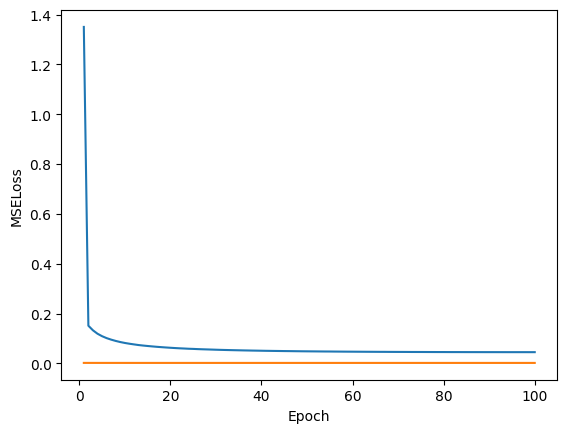

In [74]:
n=len(history['train'])
epoch=[i for i in range(1,n+1)]
plt.plot(epoch,history['train'],label="Training curve")
plt.plot(epoch,history['val'],label="Validation curve")

plt.ylabel("MSELoss")
plt.xlabel("Epoch")

plt.show()

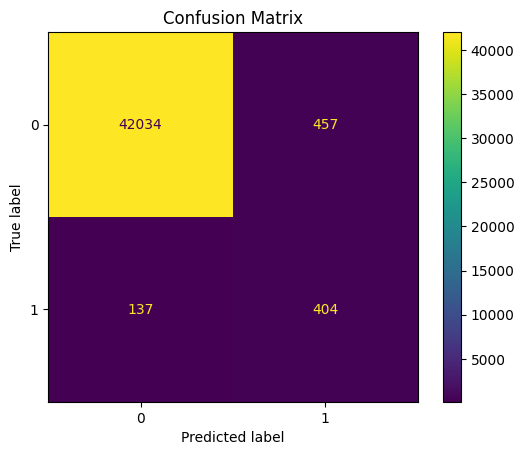

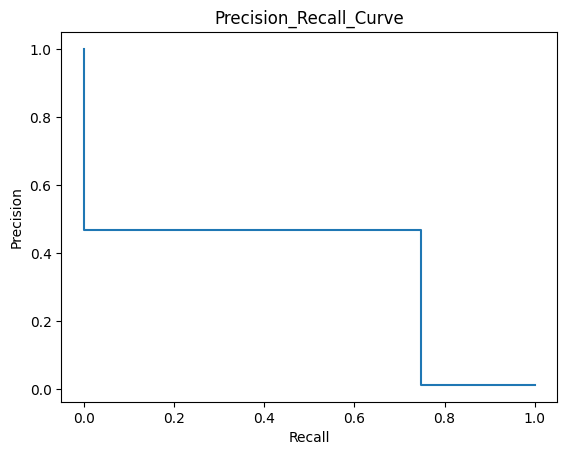

roc_auc 0.8680050153928432


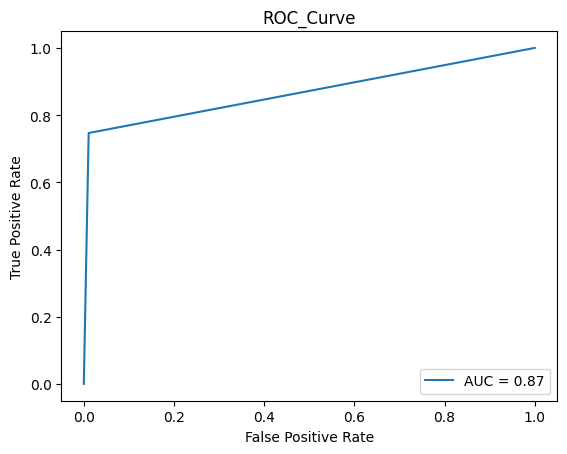

   f1_score  accuracy_score  precision_score  recall_score
0   0.57632        0.986196         0.469222      0.746765


In [75]:
ypred=model.predict(test_loader)
ypred=inverse_transform_target(ypred)
evaluation(ytest,ypred)

#### Questions
1. Combien de couche utilisé dans notre couche d'encodeur ?
2. Quelle dimension pour la variable latente(la dimension de des donnée à la sortie des de la couche d'encodeur) ?
3. Quelle est la bonne initialisation des poids de notre réseaux (Quelle fonction utilisée) ?
4. Quel algo d'optimization utilisé (SGD, Adam, ...)?
5. Quelle fonction d'activation utilisée ?
6. Quelle pourcentage de contamination utilisé ?
7. Comment détecter des problèmes de vanishing ou exploding gradient ?

Visualisation TSNE

In [77]:
df = pd.read_csv('/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/creditcard.csv', sep=',')
label = df.iloc[:, -1].copy()
df = df.drop(['Class', 'Time'], axis=1)
df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

In [78]:
#Creation de DataLoader pytorch (Just un objet qui permet d'itérer plus faciler sur l'entièreté de la dataset)
pytorch_dataset = AE_Dataset(df)
loader=DataLoader(dataset=pytorch_dataset,batch_size=10)

In [79]:
viz_y = model.predict(loader)
viz_y[viz_y == 1] = 0 # -1 == anomaly, else 1
viz_y[viz_y == -1] = 1

In [80]:
import pickle
src_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/src"

In [81]:
with open(src_path + "/X_embedded_creditcard.pickle", "rb") as file:
    X_embedded = pickle.load(file)

In [82]:
with open(src_path + "/embedded_index_creditcard.pickle", "rb") as file:
    index = pickle.load(file)

Text(0.5, 1.0, 'Local Outlier Factor')

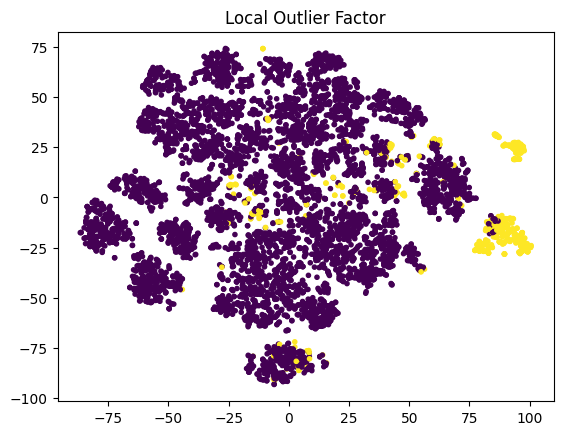

In [83]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=viz_y[index], marker='.')
plt.title("Local Outlier Factor")

Backdoor

In [84]:
# Reprodductibilité
torch.manual_seed(42)

# Creation Dataset
file_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/UNSW_NB15_traintest_backdoor.csv"
#file_path = "/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv"
dataset = CustomDataset(file_path=file_path,scaler=MinMaxScaler())

xtrain, ytrain = dataset.get_train_data()
xtest, ytest = dataset.get_test_data()


#Creation de DataLoader pytorch (Just un objet qui permet d'itérer plus faciler sur l'entièreté de la dataset)
pytorch_train_dataset = AE_Dataset(xtrain)
pytorch_test_dataset = AE_Dataset(xtest)
train_loader=DataLoader(dataset=pytorch_train_dataset,batch_size=100)
test_loader=DataLoader(dataset=pytorch_test_dataset,batch_size=10)

#Creation de modeèle
model=AutoEncoder(input_size=196,latent_size=10,output_size=196,contamination=0.03,dropout=0.3,device="cuda")

#Creation des paramètres d'entrînement du modèle
optimizer=optim.SGD(lr=1e-1, params=model.parameters(),momentum=0.9) # Optimiseur
scheduler = LinearLR(optimizer, start_factor=1e-2, end_factor=1e-6, total_iters=100) # Permet de changer le learning rate au cours de l'apprentissage

                                                                                    #Plus on se rapproche du minimun plus le learning devient faible afin d'éviter les rebond et d'assurer la convergence vers le minimum
loss_fn=nn.MSELoss() # La fonction de perte

history=model.fit(train_loader,test_loader,optimizer,scheduler,loss_fn,epochs=100)#Entraînement du modèle

EPOCHS : 1
SGD lr 0.00100000 -> 0.00099000
Loss 0.28789297010749576 vs Validation_loss  0.03619503924545833
EPOCHS : 2
SGD lr 0.00099000 -> 0.00098000
Loss 0.24316485945135355 vs Validation_loss  0.03163694602049578
EPOCHS : 3
SGD lr 0.00098000 -> 0.00097000
Loss 0.21509672226384283 vs Validation_loss  0.028535070516159097
EPOCHS : 4
SGD lr 0.00097000 -> 0.00096000
Loss 0.19480152701959014 vs Validation_loss  0.02616259914235657
EPOCHS : 5
SGD lr 0.00096000 -> 0.00095001
Loss 0.17868283474817873 vs Validation_loss  0.024228365125615832
EPOCHS : 6
SGD lr 0.00095001 -> 0.00094001
Loss 0.16542534152045846 vs Validation_loss  0.022630271940695314
EPOCHS : 7
SGD lr 0.00094001 -> 0.00093001
Loss 0.15436454731971025 vs Validation_loss  0.02129558764692331
EPOCHS : 8
SGD lr 0.00093001 -> 0.00092001
Loss 0.14505321007221939 vs Validation_loss  0.020176295843100052
EPOCHS : 9
SGD lr 0.00092001 -> 0.00091001
Loss 0.13721131900325417 vs Validation_loss  0.019235843558168635
EPOCHS : 10
SGD lr 0.00

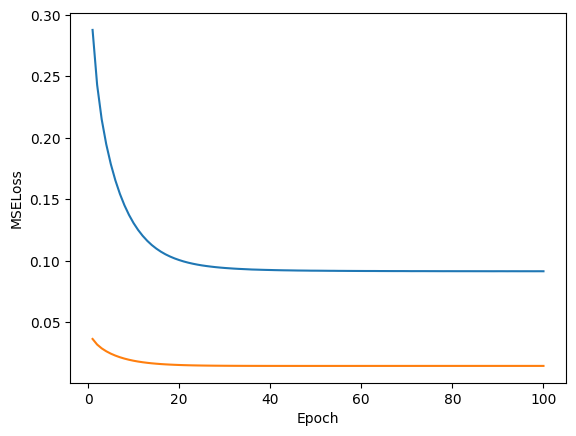

In [85]:
n=len(history['train'])
epoch=[i for i in range(1,n+1)]
plt.plot(epoch,history['train'],label="Training curve")
plt.plot(epoch,history['val'],label="Validation curve")

plt.ylabel("MSELoss")
plt.xlabel("Epoch")

plt.show()

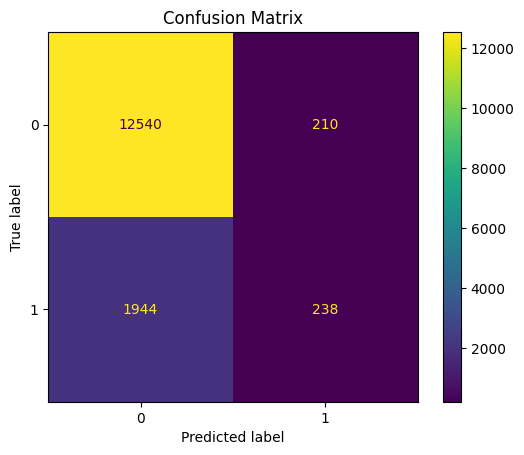

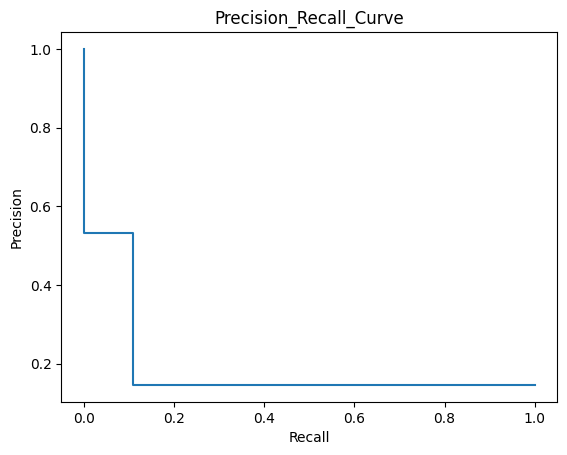

roc_auc 0.5463018277888608


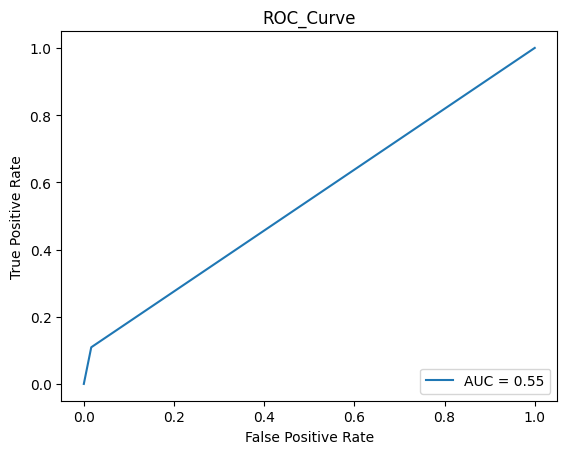

   f1_score  accuracy_score  precision_score  recall_score
0  0.180989        0.855746          0.53125      0.109074


In [86]:
ypred=model.predict(test_loader)
ypred=inverse_transform_target(ypred)
evaluation(ytest,ypred)

Visualisation TSNE BACKDOOR

In [87]:
df = pd.read_csv('/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/UNSW_NB15_traintest_backdoor.csv', sep=',')
label = df.iloc[:, -1].copy()
df = df.drop(['class'], axis=1)
df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

In [88]:
#Creation de DataLoader pytorch (Just un objet qui permet d'itérer plus faciler sur l'entièreté de la dataset)
pytorch_dataset = AE_Dataset(df)
loader=DataLoader(dataset=pytorch_dataset,batch_size=10)

In [89]:
viz_y = model.predict(loader)
viz_y[viz_y == 1] = 0 # -1 == anomaly, else 1
viz_y[viz_y == -1] = 1

In [90]:
import pickle
src_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/src"

In [91]:
with open(src_path + "/X_embedded_backdoor.pickle", "rb") as file:
    X_embedded = pickle.load(file)

In [92]:
with open(src_path + "/embedded_index_backdoor.pickle", "rb") as file:
    index = pickle.load(file)

Text(0.5, 1.0, 'Auto encoder')

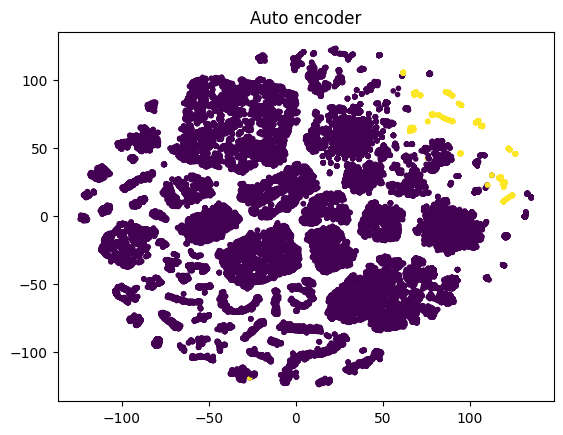

In [93]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=viz_y[index], marker='.')
plt.title("Auto encoder")